In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import math
import random

from copy import deepcopy

# Create chromosome blueprint, initialize the population, and create a way to display
# the population

class Chromosome:
    
    def __init__(self, genes = None):
        
        if(genes == None):
            x = np.random.randint(-10, 10)
            y = np.random.randint(-10, 10)
            
        else:
            x = genes["x"]
            y = genes["y"]
    
        #self.genes = {"x": x}
        self.genes = {"x": x, "y": y}
        
        self.fitness = None
        
def create_population(num_chromosomes):
    
    population = []
    for i in range(num_chromosomes):
        population.append(Chromosome())
    return population 

def display_population(population, string):
    
    print(f"\nPopulation after {string}:\n")
    for i, chromosome in enumerate(population):
        print("Chromosome %s : x = %s, y = %s, fitness = %s" 
              % (i, chromosome.genes["x"], chromosome.genes["y"], chromosome.fitness))



# Create fitness function, f(x) = x^2
# maps a chromosome representation into a scalar value

def fitness(x, y):
    
    #x^2
    return (x ** 2)
    
    #Matyas Function
    #return (x ** 2 + y ** 2) * 0.26 - (x * y) * 0.48
    
    #Himmelblau's Function
    #return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

# Create function to update each chromosome's fitness

def evaluate_population(population):

    for chromosome in population:
        chromosome.fitness = fitness(chromosome.genes["x"], chromosome.genes["y"])
        
    scores = [chromosome.fitness for chromosome in population]
    
    indices = np.argsort(scores) #this sorts each row from greatest to least and creates a list of indices
    
    return list(np.asarray(population)[indices])

# Create selection function(s). this is the function that chooses parents to reproduce.

# generation_gap defaults to 0, will only be populated if elitism is true

# Max num selected would be something to experiment with / improve on! 

def roulette_wheel(population, p_num_selected, epsilon = 1e-4, max_num_selected = 3):
    
    sum_of_fitnesses = calculate_sum_of_fitnesses(population)
    
    # calculate relative fitness. Roulet wheel made
    
    try:
        scores = [1 - (chromo.fitness / (sum_of_fitnesses + epsilon)) for chromo in population]
    except:
        #print("LOOK AT ME: ", sum_of_fitnesses)
        from IPython import embed
        embed()
        #exit()
        
    # spin the created roulet wheel --> P selected chromos
    
    selected = []
    
    for i in range(p_num_selected):
        
        # If parent is already selected, pick another? 
        
        while(1):
            
            sigma = random.uniform(0, np.max(scores))

            total = 0
            for j in range(len(scores)):
                total = total + scores[j]
                if(total >= sigma):
                    break

            the_chosen = population[j]
            
            #print("Chosen: x = %s, y = %s" % (the_chosen.genes["x"], the_chosen.genes["y"]))

            # get number of times chosen has appeared in selected parents

            total = 0
            for chromosome in selected:
                if(the_chosen == chromosome):
                    total = total + 1
            
            if(total < max_num_selected):
                break  
            else:
                scores.pop(j)
                population.pop(j)
                 
        selected.append(the_chosen)
        #print("CHOSEN IS ADDED")

    return selected 

def calculate_sum_of_fitnesses(population):
    sum_of_fitnesses = 0
    for chromosome in population:
        sum_of_fitnesses += chromosome.fitness
    return sum_of_fitnesses

def create_matches(parent_group, req_num_parents):
    
    num_groups = int(len(parent_group) / req_num_parents)
    
    # get sets of subgroups that are going to produce one child
    
    couples = []
        
    for i in range(num_groups):
        
        # first get the indices of parents for each subgroup (this would be something to improve on :-))
        
        indices = [ np.random.randint(0, len(parent_group)) 
                    for j in range(req_num_parents) ]
        
        # populate subgroup with chromosomes 
        
        group = [parent_group[index] for index in indices]
        
        couples.append(group)
    
    return couples

def selection(population, elite_percent, req_num_parents = 2):
    
    parents = []
    
    if elite_percent > 0:
        
        elite_group = []
        
        num_chromosomes = len(population)
        e_num_selected = math.ceil(elite_percent * num_chromosomes) 
        
        # most elite chromos automatically get into next generation
        
        for i in range(e_num_selected):
            elite_group.append(population[i])
    
    else:
        elite_group = []
        e_num_selected = 0
        
    # let's build up the rest of the parents list using roulette wheel.
   
    num_chromosomes = len(population)
    p_num_selected = int((num_chromosomes - e_num_selected) * req_num_parents)
    
    parent_group = roulette_wheel(population, p_num_selected, max_num_selected=2)
    
    parent_group = create_matches(parent_group, req_num_parents)

    return elite_group, parent_group

# Create simplex cross over function(s)
# you can choose to have two parents, three parents, k parents
# if you do k-point, stick with two parents
###### i really don't know what kind of crossover i did here ####

def calculate_mean(population):
    
    num_genes = len(population[-1].genes.keys())
    
    mean = np.zeros(num_genes)
    for chromosome in population:
        genes = chromosome.genes
        for i, current_gene in enumerate(genes.keys()):
            mean[i] += chromosome.genes[current_gene]
        
    return mean / len(population)
        
def simplex_crossover(parent_groups):
    
    children = []
    for parents in parent_groups:
    
        # select random parent for simplex equation 
        
        index = np.random.randint(0, len(parents))
        rand_chromo = parents[index]
        
        # get all possible genes
        
        all_genes = parents[-1].genes.keys()
        
        # run simplex on each gene
        
        simplexed_genes = {}
        for current_gene in all_genes:
            
            epsilon = np.random.rand()
            info = [chromo.genes[current_gene] for chromo in parents] 
            
            # This would be an area to improve!! Make better selection for rand chromo.
            
            agg = math.ceil(np.mean(info) + (rand_chromo.genes[current_gene] - np.mean(info)) * epsilon)
            
            simplexed_genes[current_gene] = agg
        
        # create child from simplexed genes
        
        children.append(Chromosome(simplexed_genes))
    
    return children

# implement mutation here

def mutation(children, mutate_chance, mutate_scale = 0.5):
    
    kiddos = []
    
    for child in children:
        
        alpha = np.random.rand()
        
        # mutate if random allows 
        
        if(alpha <= mutate_chance):
            
            # mutate all child genes
            
            all_genes = child.genes.keys()
        
            for current_gene in all_genes:
                flip = -1 if(np.random.rand() >= 0.5) else 1
                offset = flip * child.genes[current_gene] * mutate_scale
                child.genes[current_gene] = math.ceil(child.genes[current_gene] + offset)
            
        kiddos.append(child)
    
    return kiddos 

def mutation_constant(population, generation):
    
    # the strategy is to decrease sigma as the number of generations increases so we get 
    # small variations near the optimum, preventing individuals from jumping over the 
    # minimum
    
    if generation >= num_generations * (3/4):
            sigma = 0.05
    elif generation < num_generations * (3/4) and generation >= num_generations / 2:
            sigma = 0.1
    elif generation < num_generations / 2 and generation >= num_generations / 4:
            sigma = 0.15
    elif generation < num_generations / 4:
            sigma = 0.2
            
    # each individual is mutated by adding a gaussian random value
    gaussian = random.uniform(0,sigma)
    # can I make this value hover around zero?
    #gaussian = random.uniform(-sigma,sigma)
    
    for chromosome in population:
        chromosome.genes["x"] = chromosome.genes["x"] + gaussian
        
    # evaluate fitness before returning
    evaluate_population(population)
    
    return population

# stats methods
def get_min(population):
    
    fitness = []
    for chromosome in population:
        fitness.append(chromosome.fitness)
    return min(fitness)
    
def get_max(population):
    fitness = []
    for chromosome in population:
        fitness.append(chromosome.fitness)
    return max(fitness)

def get_mean(population):
    fitness = []
    sum = 0
    for chromosome in population:
        sum += chromosome.fitness
    return sum / len(population)

In [2]:
# this is the main function #
    
num_chromosomes = 20
num_generations = 50
elite_percent = 0
mutate_chance = 0.9
display_target = 5

fitness_min = []
fitness_max = []
fitness_avg = []

# Create population and make backup for plotting 

pop = create_population(num_chromosomes)

orig_pop = deepcopy(pop)

generation = 1

for i in range(num_generations):
    
    if(i % display_target == 0):
        nl = "\n"
        print(f"{nl}Generation {generation}{nl}")
    
    # Calcuate fitness (the environment scored each chromosome) and update analytics

    pop = evaluate_population(pop)
    
    if(i % display_target == 0):
    
        if(i == 0):
            display_population(pop, "Initial")
        else:
            display_string = str(i)
            display_population(pop, f"Gen {i}")
        
    fitness_min.append(get_min(pop))
    fitness_max.append(get_max(pop))
    fitness_avg.append(get_mean(pop))
    
    # Selection for children and optional elitism 
    
    elite_group, parent_group = selection(deepcopy(pop), elite_percent)
    
    # Create some kids, via cross-over / mutation 
    
    children = simplex_crossover(parent_group)
    
    #display_population(children, "children")
    
    children = mutation(children, mutate_chance)
    
    #display_population(children,"mutation")
    
    # Update population for new generation 
    
    pop = elite_group + children
    
    if(i % display_target == 0 and elite_percent > 0):
        display_population(elite_group, "elitism")
    
    # Update generations 
    
    generation +=1
    


Generation 1


Population after Initial:

Chromosome 0 : x = 0, y = 1, fitness = 0
Chromosome 1 : x = -1, y = -6, fitness = 1
Chromosome 2 : x = -1, y = 4, fitness = 1
Chromosome 3 : x = 2, y = 6, fitness = 4
Chromosome 4 : x = 2, y = -6, fitness = 4
Chromosome 5 : x = 2, y = 8, fitness = 4
Chromosome 6 : x = -2, y = -7, fitness = 4
Chromosome 7 : x = -3, y = 9, fitness = 9
Chromosome 8 : x = 3, y = -8, fitness = 9
Chromosome 9 : x = 3, y = 6, fitness = 9
Chromosome 10 : x = -5, y = -2, fitness = 25
Chromosome 11 : x = 5, y = 7, fitness = 25
Chromosome 12 : x = 6, y = -9, fitness = 36
Chromosome 13 : x = 6, y = 5, fitness = 36
Chromosome 14 : x = 9, y = -3, fitness = 81
Chromosome 15 : x = 9, y = 4, fitness = 81
Chromosome 16 : x = -9, y = 7, fitness = 81
Chromosome 17 : x = -9, y = 7, fitness = 81
Chromosome 18 : x = 9, y = -10, fitness = 81
Chromosome 19 : x = -10, y = 8, fitness = 100

Generation 6


Population after Gen 5:

Chromosome 0 : x = 0, y = 5, fitness = 0
Chromosome 1 : x

<IPython.core.display.Javascript object>


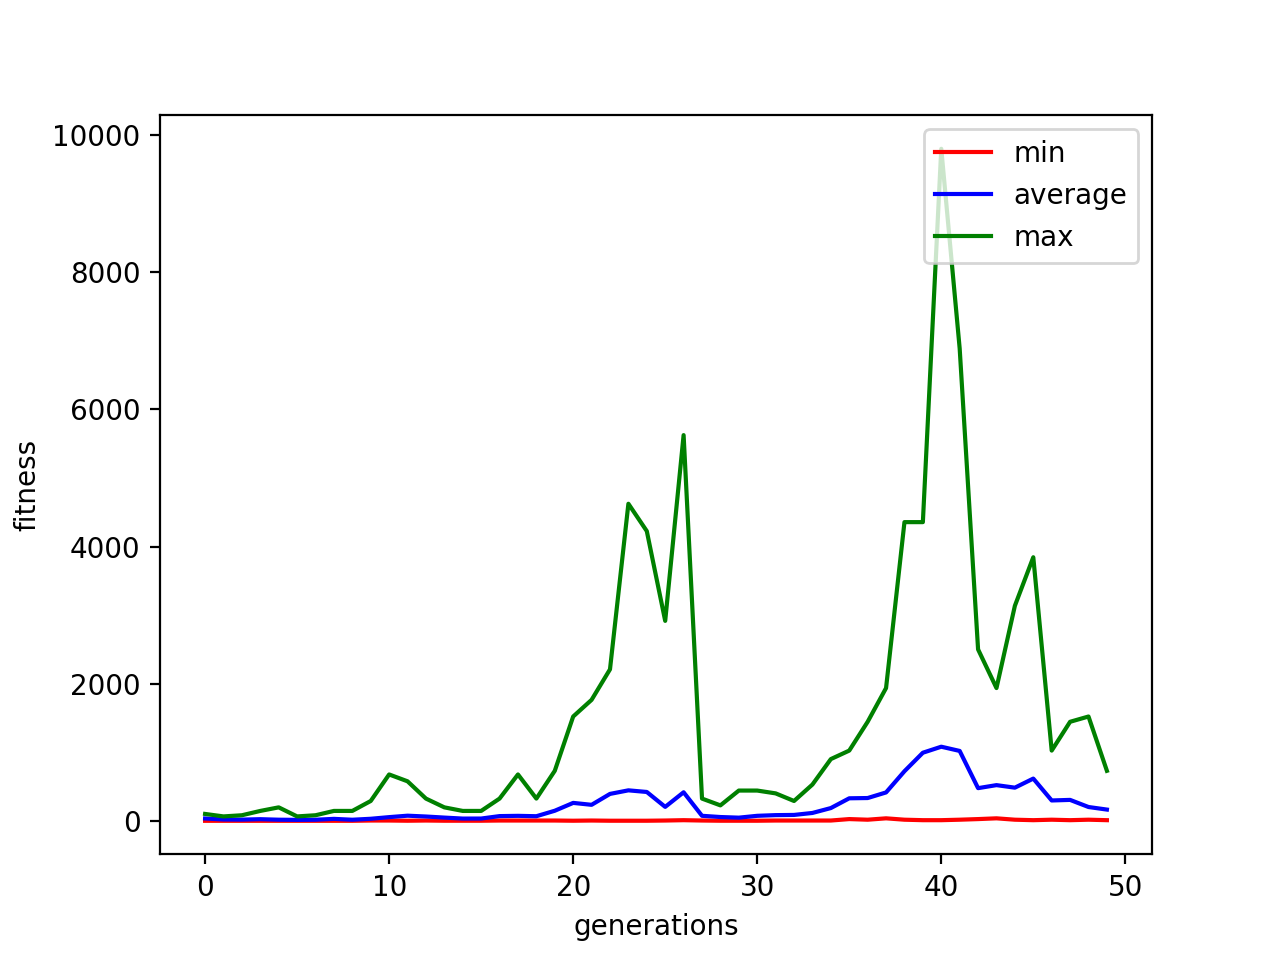

In [3]:
# Plot Results

#plt.style.use("seaborn")
plt.plot(np.arange(0, num_generations, 1), fitness_min,'r', label = 'min')
plt.plot(np.arange(0, num_generations, 1), fitness_avg,'b', label = 'average')
plt.plot(np.arange(0, num_generations, 1), fitness_max,'g', label = 'max')
plt.ylabel('fitness')
plt.xlabel('generations')
plt.legend(loc='upper right')

In [7]:
def create_world(x_s, y_s, offset = 0.15, alpha = 0.1):

    min_x = np.min(x_s) + (offset * np.min(x_s))
    max_x = np.max(x_s) + (offset * np.max(x_s))

    min_y = np.min(y_s) + (offset * np.min(y_s))
    max_y = np.max(y_s) + (offset * np.max(y_s))

    x_vals = np.arange(min_x, max_x, alpha)
    y_vals = np.arange(min_y, max_y, alpha)

    xx, yy = np.meshgrid(x_vals, y_vals)

    zz = fitness(xx, yy)
    
    return xx, yy, zz

<IPython.core.display.Javascript object>


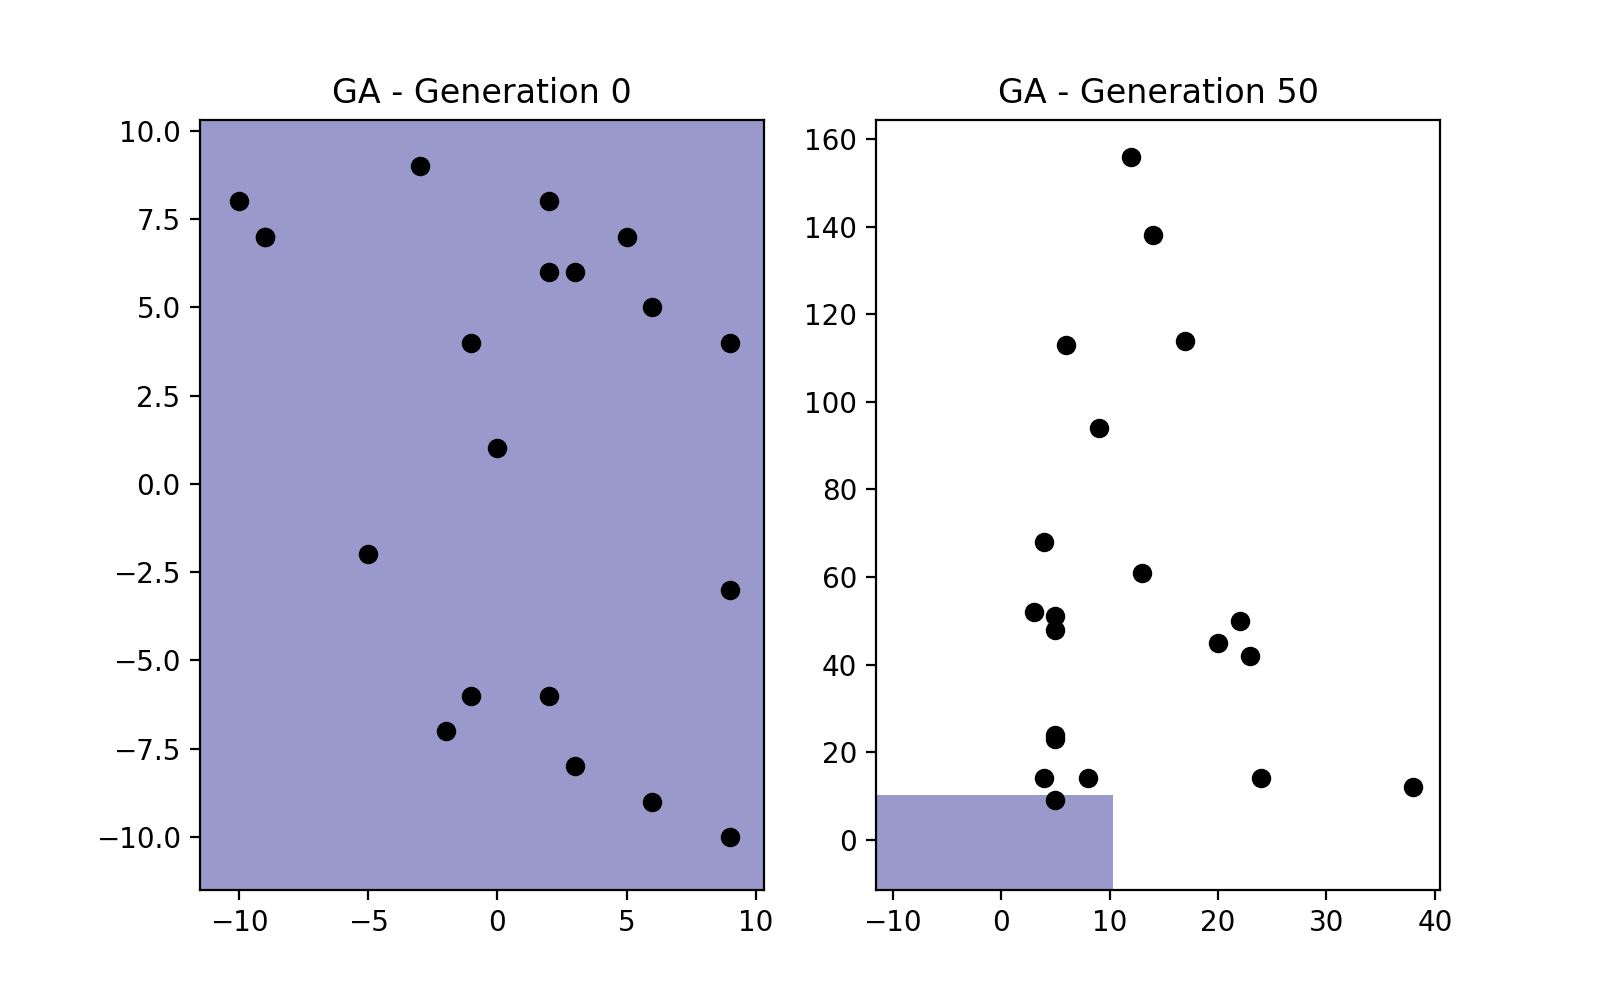

In [8]:
# Gather population of interest (generation = start)

x_s_orig, y_s_orig = np.zeros(num_chromosomes), np.zeros(num_chromosomes)

for i, chromosome in enumerate(orig_pop):
    x_s_orig[i] = chromosome.genes["x"]
    y_s_orig[i] = chromosome.genes["y"]

# Gather population of interest (generation = end)

x_s_final, y_s_final = np.zeros(num_chromosomes), np.zeros(num_chromosomes)

for i, chromosome in enumerate(pop):
    x_s_final[i] = chromosome.genes["x"]
    y_s_final[i] = chromosome.genes["y"]   

# Create worlds (2D, 3D)

xx, yy, zz = create_world(x_s_orig, y_s_orig)

fig,ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].contourf(xx, yy, zz, levels = np.logspace(-9, 9, 50), cmap = "jet", alpha = 0.4)
ax[0].set_title("GA - Generation 0", fontsize = 12)
ax[0].scatter(x_s_orig, y_s_orig, c = "black")

# Plot 2D world

ax[1].contourf(xx, yy, zz, levels = np.logspace(-9, 9, 50), cmap = "jet", alpha = 0.4)
ax[1].set_title("GA - Generation %s" % (num_generations), fontsize = 12)
ax[1].scatter(x_s_final, y_s_final, c = "black")

<IPython.core.display.Javascript object>


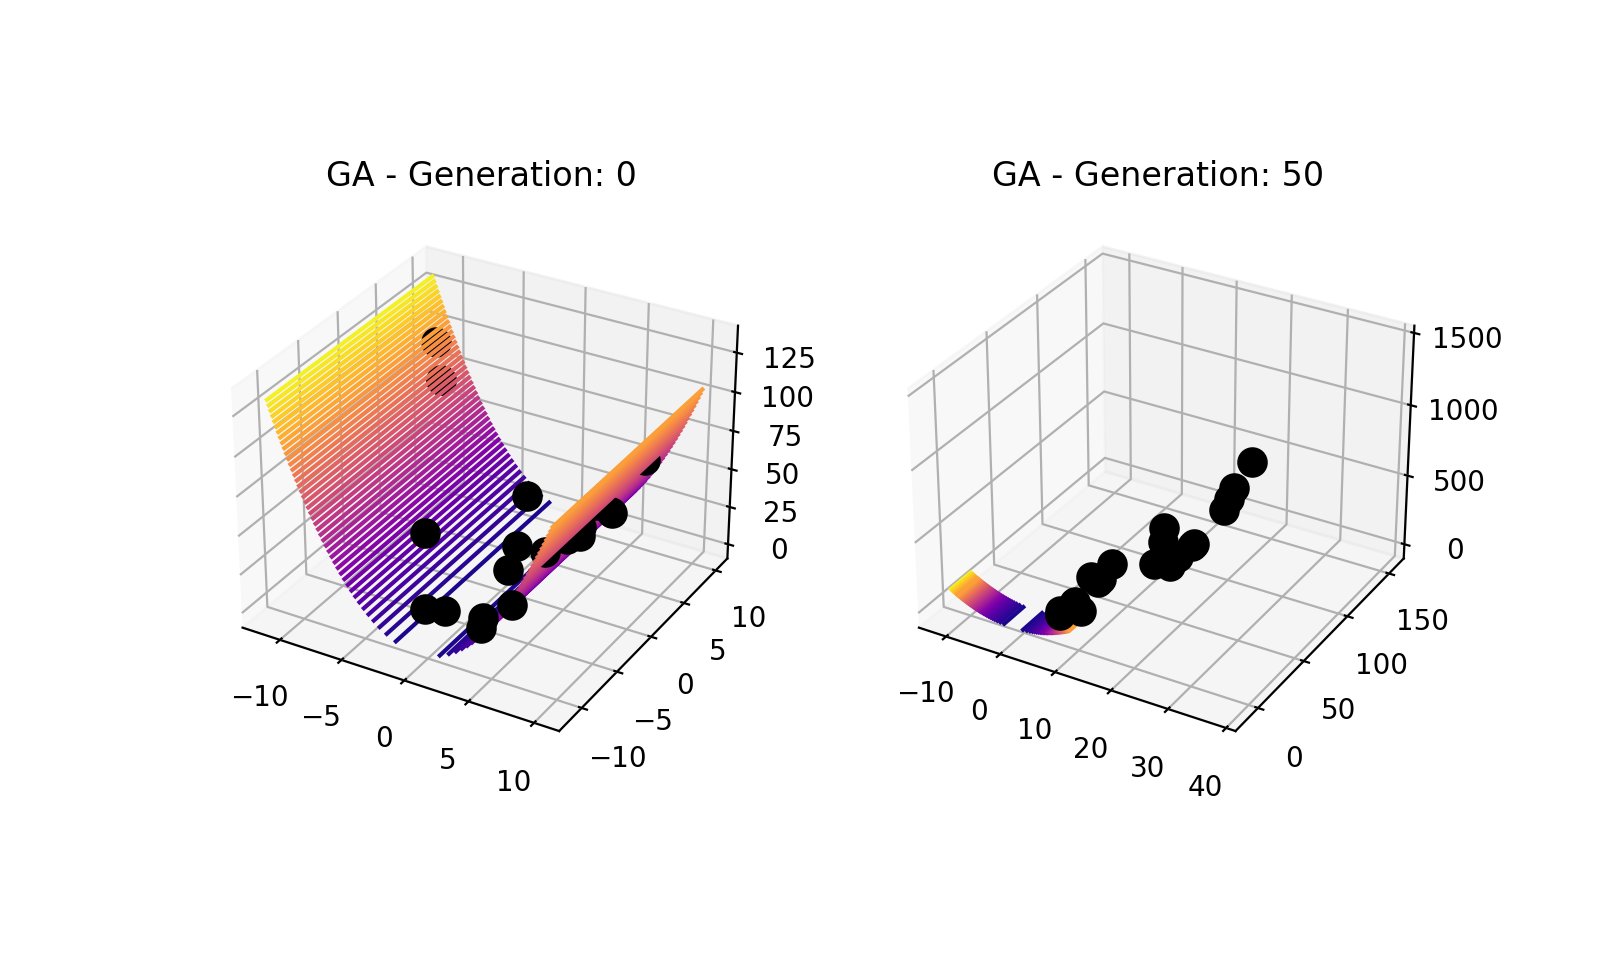

Text(0.5, 0.92, 'GA - Generation: 50')

In [11]:
fig = plt.figure(figsize=plt.figaspect(0.6))
ax = fig.add_subplot(1,2,1,projection='3d')

#fig,ax = plt.subplots(1,2,figsize=(8,5))
#ax[0] = plt.axes(projection = "3d")
p = ax.contour(xx, yy, zz, 50, cmap = "plasma")
ax.scatter(x_s_orig, y_s_orig, fitness(x_s_orig, y_s_orig), c = "black", s = 100, depthshade=False)
ax.set_title("GA - Generation: 0", fontsize = 12)
#fig.colorbar(p, location = "bottom")

ax = fig.add_subplot(1, 2, 2, projection='3d')

#ax[1] = plt.axes(projection = "3d")
p = ax.contour(xx, yy, zz, 50, cmap = "plasma")
ax.scatter(x_s_final, y_s_final, fitness(x_s_final, y_s_final), c = "black", s = 100, depthshade=False)
ax.set_title("GA - Generation: %s" % (num_generations), fontsize = 12)
#fig.colorbar(p, location = "bottom")